In [1]:
import numpy as np
import pandas as pd
import os
from keras.callbacks import EarlyStopping

from qrnn import get_model, qloss
from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qrnn, get_test_set_qrnn

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
data_set = 'London_2013'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 2002/2002 [01:16<00:00, 26.32it/s]


In [3]:
month = 1
n_clusters = 2
method = 'hierarchical/euclidean'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [5]:
error_train = np.zeros((24, 3))
error_test = np.zeros((24, 3))

for i in range(1, n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)
    
    total_series = np.vstack((sub_series, weather, week, day))
    
    test = total_series[:, -168:]
    train = total_series[:, :-168]
    
    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])
    
    for lag in range(1, 25):
        for d in range(1, 4):
            print('lag:', lag, ', d:', d)

            trainX, trainY = get_train_set_qrnn(train, lag, d)
            testX, testY = get_test_set_qrnn(train, test, lag, d)

            # Parameters
            input_dim = (lag + d) * 2 + 3
            num_hidden_layers = 1
            num_unit = 10
            num_units = [num_unit, num_unit]
            act = ['relu', 'relu']

            # Get model
            model = get_model(input_dim, num_units, act, num_hidden_layers)

            # Train
            hist = model.fit(x=trainX, y=trainY, epochs=300, verbose=0)

            pred = model.predict(x=trainX)
            error_train[lag-1, d-1] = qloss(trainY, pred)

            # Test
            pred = model.predict(x=testX)
            error_test[lag-1, d-1] = qloss(testY, pred)

    break

lag: 1 , d: 1
lag: 1 , d: 2
lag: 1 , d: 3
lag: 2 , d: 1
lag: 2 , d: 2
lag: 2 , d: 3
lag: 3 , d: 1
lag: 3 , d: 2
lag: 3 , d: 3
lag: 4 , d: 1
lag: 4 , d: 2
lag: 4 , d: 3
lag: 5 , d: 1
lag: 5 , d: 2
lag: 5 , d: 3
lag: 6 , d: 1
lag: 6 , d: 2
lag: 6 , d: 3
lag: 7 , d: 1
lag: 7 , d: 2
lag: 7 , d: 3
lag: 8 , d: 1
lag: 8 , d: 2
lag: 8 , d: 3
lag: 9 , d: 1
lag: 9 , d: 2
lag: 9 , d: 3
lag: 10 , d: 1
lag: 10 , d: 2
lag: 10 , d: 3
lag: 11 , d: 1
lag: 11 , d: 2
lag: 11 , d: 3
lag: 12 , d: 1
lag: 12 , d: 2
lag: 12 , d: 3
lag: 13 , d: 1
lag: 13 , d: 2
lag: 13 , d: 3
lag: 14 , d: 1
lag: 14 , d: 2
lag: 14 , d: 3
lag: 15 , d: 1
lag: 15 , d: 2
lag: 15 , d: 3
lag: 16 , d: 1
lag: 16 , d: 2
lag: 16 , d: 3
lag: 17 , d: 1
lag: 17 , d: 2
lag: 17 , d: 3
lag: 18 , d: 1
lag: 18 , d: 2
lag: 18 , d: 3
lag: 19 , d: 1
lag: 19 , d: 2
lag: 19 , d: 3
lag: 20 , d: 1
lag: 20 , d: 2
lag: 20 , d: 3
lag: 21 , d: 1
lag: 21 , d: 2
lag: 21 , d: 3
lag: 22 , d: 1
lag: 22 , d: 2
lag: 22 , d: 3
lag: 23 , d: 1
lag: 23 , d: 2
lag: 23

In [6]:
np.save('qrnn_train.npy', np.array(error_train))
np.save('qrnn_test.npy', np.array(error_test))

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

train = np.load('qrnn_train.npy')
test = np.load('qrnn_test.npy')

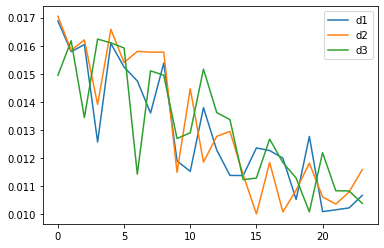

In [2]:
plt.plot(train[:, 0])
plt.plot(train[:, 1])
plt.plot(train[:, 2])
plt.legend(['d1', 'd2', 'd3'], loc='upper right')

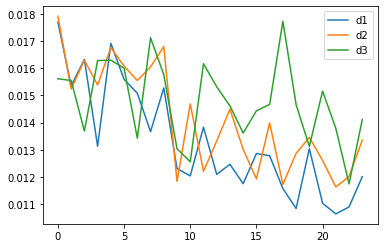

In [3]:
plt.plot(test[:, 0])
plt.plot(test[:, 1])
plt.plot(test[:, 2])
plt.legend(['d1', 'd2', 'd3'], loc='upper right')